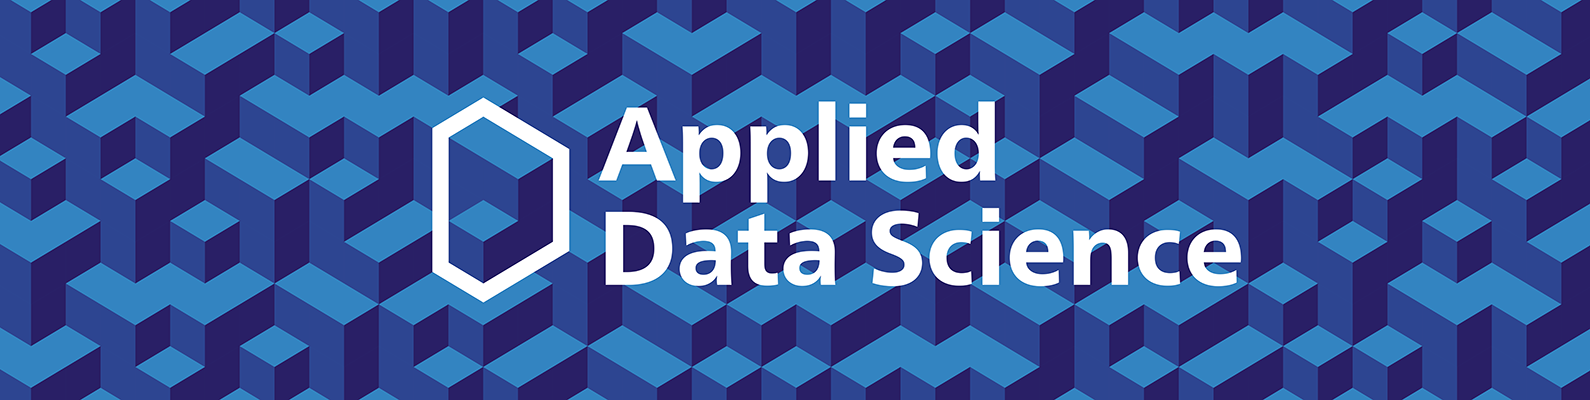

In [2]:
#Импортирование библиотек
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import datasets, linear_model
from sklearn.metrics import classification_report
import math
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score , cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing

%matplotlib inline

In [3]:
#Загрузка данных
australia = pd.read_csv('weatherAUS.csv')
australia.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


Rain:  110316
Not Rain :  31877


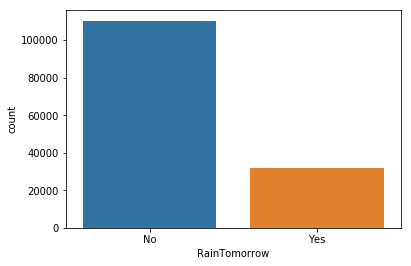

In [4]:
#Посчитаем априорное распределение выборки
plot_sb = sb.countplot(australia.RainTomorrow, label='Total')
Rain, NotRain = australia.RainTomorrow.value_counts()
print('Rain: ',Rain)
print('Not Rain : ',NotRain)

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

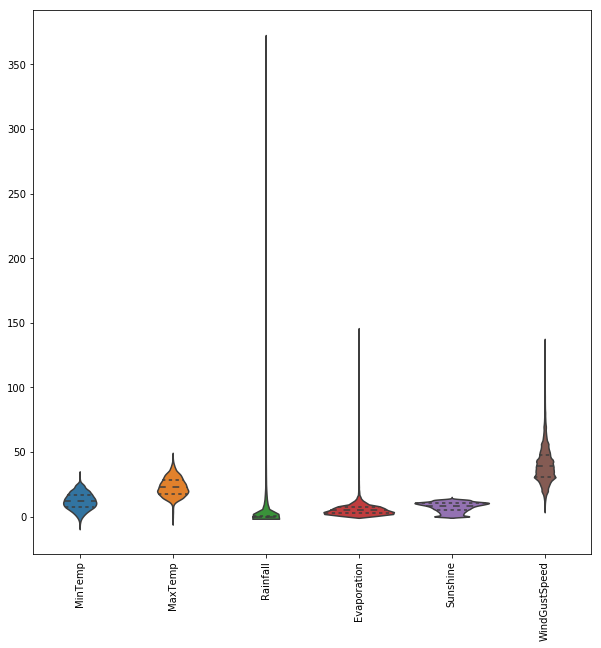

In [5]:
#Визуализация данных
# Setting the plt object
plt.figure(figsize=(10,10))
# Setting the violinplot objetc with respecitve atributes
sb.violinplot(data=australia[australia.columns[0:10]], split=True, inner="quart")
# Rotation of x ticks
plt.xticks(rotation=90)

In [6]:
#Проверка на пропущенные значения
print('Всего строк : {}'.format(len(australia)))
australia.isna().sum()/len(australia) * 100

Всего строк : 145460


Date              0.000000
Location          0.000000
MinTemp           1.020899
MaxTemp           0.866905
Rainfall          2.241853
Evaporation      43.166506
Sunshine         48.009762
WindGustDir       7.098859
WindGustSpeed     7.055548
WindDir9am        7.263853
WindDir3pm        2.906641
WindSpeed9am      1.214767
WindSpeed3pm      2.105046
Humidity9am       1.824557
Humidity3pm       3.098446
Pressure9am      10.356799
Pressure3pm      10.331363
Cloud9am         38.421559
Cloud3pm         40.807095
Temp9am           1.214767
Temp3pm           2.481094
RainToday         2.241853
RISK_MM           2.245978
RainTomorrow      2.245978
dtype: float64

In [7]:
#Удаляем столбцы, где много пропущенных данных
australia_filtr = australia.drop(['Evaporation', 'Sunshine', 'Cloud3pm', 'Cloud9am'], axis=1)

In [8]:
australia_regr = australia.dropna() 
australia_regr.RainToday = [1 if each=="Yes" else 0 for each in australia_regr.RainToday]
australia_regr.RainTomorrow = [1 if each=="Yes" else 0 for each in australia_regr.RainTomorrow]
Yregr =  australia_regr.RISK_MM
Xregr = australia_regr.drop(['RainTomorrow', 'RISK_MM', 'Evaporation' , 'WindDir9am' , 'WindDir3pm'
                             , 'Sunshine', 'Cloud3pm', 'Cloud9am', 'WindGustSpeed' , 'WindGustDir' , 'Location', 'Date'], axis=1)


/usr/local/lib/python3.5/dist-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5]), <a list of 12 Text xticklabel objects>)

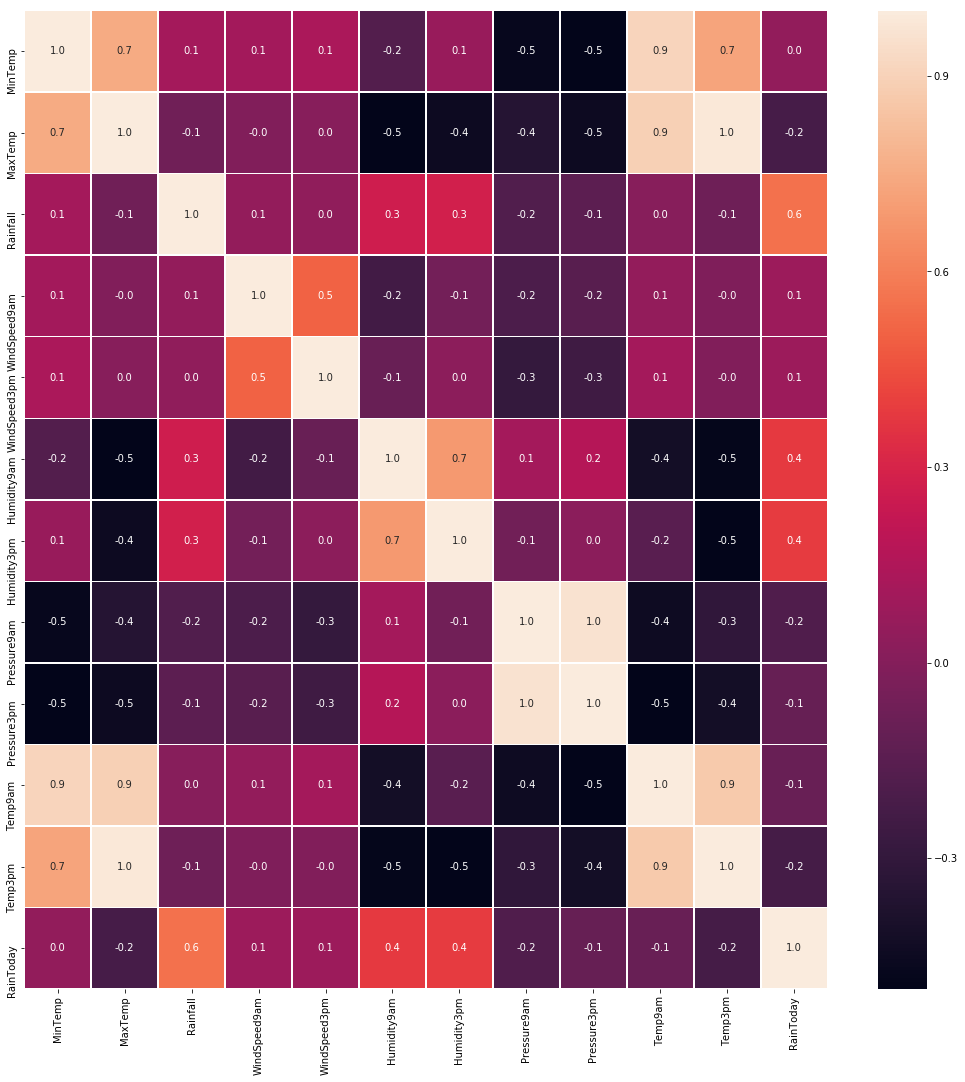

In [9]:
#Считаем корреляцию между переменными
f, ax = plt.subplots(figsize=(18, 18))
sb.heatmap(Xregr.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.xticks(rotation=90)

In [11]:
#Построим базовую логистическую регрессию 
#Создание целевой переменной

Xregr_nocor = Xregr.drop(['MaxTemp', 'MinTemp', 'Pressure9am'], axis=1)

print('Строк без пропусков : {}'.format(len(Xregr)))

Xscaled = (Xregr_nocor - Xregr_nocor.mean()) / (Xregr_nocor.std())
X_train, X_test, y_train, y_test = train_test_split(Xscaled, Yregr, test_size=0.3, random_state=1)
reg = linear_model.Ridge (alpha = 10)
reg.fit(X_train, y_train) 

from sklearn.metrics import mean_squared_error, r2_score
y_pred = reg.predict(X_test)

print('Coefficients: \n', reg.coef_)
# The mean squared error
print("Mean squared error train / test: {} / {}".format(mean_squared_error(y_train, reg.predict(X_train)) 
                                                        , mean_squared_error(y_test, y_pred)))
# Explained variance score: 1 is perfect prediction
print('Variance score train / test : {} / {}'.format(r2_score(y_train, reg.predict(X_train))
                                                      , r2_score(y_test, y_pred)))


Строк без пропусков : 56420
Coefficients: 
 [ 1.88989486  0.32380898 -0.31913956 -0.73092401  3.56289754 -1.11560236
 -1.40570793  1.98310409 -0.03850107]
Mean squared error train / test: 62.26008431999587 / 63.28540101213816
Variance score train / test : 0.1796452016947454 / 0.17877303743919004


In [12]:
australia_filtr.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'WindGustDir',
       'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am',
       'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am',
       'Pressure3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RISK_MM',
       'RainTomorrow'],
      dtype='object')

In [13]:
#Синтезируем пропуски
bool_series=pd.notnull(australia_filtr['RISK_MM'])
australia_filtr=australia_filtr[bool_series]
#australia_filtr = australia_filtr.dropna(subset=['RISK_MM', 'RainTomorrow'])
australia_filtr_regr = australia_filtr.drop(["Date" , "Location" , "WindGustDir" , "WindDir9am" , "WindDir3pm" , "RainTomorrow"], axis=1)
australia_filtr_regr.RainToday = [1 if each=="Yes" else 0 for each in australia_filtr_regr.RainToday]
for col in australia_filtr_regr.columns :
    if australia_filtr_regr[col].isna().sum() < 10 * len(australia_filtr_regr) and australia_filtr_regr[col].isna().sum() > 0 :
        
        if col != "Pressure3pm":
            australia_filtr_regr[col].fillna((australia_filtr_regr[col].mean()), inplace=True)
        print("column : {} , mean : {} ".format(col , australia_filtr_regr[col].mean()))

#Удаляем кореллированные данные        
australia_filtr_regr_nocor = australia_filtr_regr.drop(['MaxTemp', 'MinTemp', 'Pressure9am'], axis=1)

column : MinTemp , mean : 12.18639972872915 
column : MaxTemp , mean : 23.226784191272316 
column : Rainfall , mean : 2.349974074311172 
column : WindGustSpeed , mean : 39.98429165758255 
column : WindSpeed9am , mean : 14.001988000994093 
column : WindSpeed3pm , mean : 18.637575861797185 
column : Humidity9am , mean : 68.84381031057072 
column : Humidity3pm , mean : 51.48260609165429 
column : Pressure9am , mean : 1017.6537584160466 
column : Pressure3pm , mean : 1015.258203537907 
column : Temp9am , mean : 16.9875085817014 
column : Temp3pm , mean : 21.687234973146396 


In [16]:
australia_tree_fl32 = pd.DataFrame()
for col in australia_filtr_regr_nocor.columns :
        australia_tree_fl32[col] = australia_filtr_regr_nocor[col].astype('float32')
australia_tree_fl32.isna().sum()/len(australia_tree_fl32) * 100        

Rainfall         0.000000
WindGustSpeed    0.000000
WindSpeed9am     0.000000
WindSpeed3pm     0.000000
Humidity9am      0.000000
Humidity3pm      0.000000
Pressure3pm      9.832411
Temp9am          0.000000
Temp3pm          0.000000
RainToday        0.000000
RISK_MM          0.000000
dtype: float64

In [19]:
## Создание целевой переменной
bool_series=pd.notnull(australia_tree_fl32['Pressure3pm'])
australia_tree= australia_tree_fl32[bool_series]
Y = australia_tree.Pressure3pm.astype('float32')
X = australia_tree.drop(['RISK_MM' , 'Pressure3pm'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1)


dtc = DecisionTreeRegressor(criterion = "mse", min_samples_leaf = 30, min_samples_split = 50)
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)
#f1_score(y_test, y_pred)
# Explained variance score: 1 is perfect prediction
print('Variance score train / test : {} / {}'.format(r2_score(y_train, dtc.predict(X_train))
                                                      , r2_score(y_test, y_pred)))


for index, row in australia_filtr_regr.iterrows():
    if (math.isnan(row.Pressure3pm)):
        australia_filtr_regr.set_value(index,'Pressure3pm',dtc.apply([row[X.columns]]))

print(australia_filtr_regr.Pressure3pm.isna().sum())

Variance score train / test : 0.48300703777275567 / 0.3623924434360313
0


In [20]:
#Еще раз строим регрессию
Y = australia_filtr_regr.RISK_MM.astype('float32')
X = australia_filtr_regr.drop(['RISK_MM'], axis=1)
Xscaled = (X - X.mean()) / (X.std())
X_train, X_test, y_train, y_test = train_test_split(Xscaled, Y, test_size=0.3, random_state=1)
reg = linear_model.Ridge(alpha = 10)
reg.fit(X_train, y_train) 

from sklearn.metrics import mean_squared_error, r2_score
y_pred = reg.predict(X_test)

print('Coefficients: \n', reg.coef_)
# The mean squared error
print("Mean squared error train / test: {} / {}".format(mean_squared_error(y_train, reg.predict(X_train)) 
                                                        , mean_squared_error(y_test, y_pred)))
# Explained variance score: 1 is perfect prediction
print('Variance score train / test : {} / {}'.format(r2_score(y_train, reg.predict(X_train))
                                                      , r2_score(y_test, y_pred)))


Coefficients: 
 [-0.30846961  0.31240042  1.83310948  1.67800833 -0.04287299 -0.90447947
 -0.17691518  3.15749144 -0.28242157 -0.07954396 -0.29970959  1.33306883
 -0.02799247]
Mean squared error train / test: 59.14915038393835 / 57.12688566973726
Variance score train / test : 0.18708433282684833 / 0.18164073211683673


In [22]:
#Строим random-forest
australia_rf = australia_filtr.drop(['Date', 'Location', 'RISK_MM'], axis=1)
australia_rf = australia_rf.dropna()

X = australia_rf.drop(['RainTomorrow'], axis=1)
Y = australia_rf.RainTomorrow
X.RainToday = [1 if each=="Yes" else 0 for each in X.RainToday]
Y = [1 if each=="Yes" else 0 for each in Y]
enc = preprocessing.LabelEncoder()
enc.fit_transform(X['WindGustDir'].fillna('A').astype('category'))
X['WindGustDirNum'] = enc.transform(X.WindGustDir.fillna('A'))
X['WindDir9amNum'] = enc.transform(X.WindDir9am.fillna('A'))
X['WindDir3pmNum'] = enc.transform(X.WindDir3pm.fillna('A'))
X = X.drop(['WindGustDir', 'WindDir9am', 'WindDir3pm'], axis = 1)
Xnew = pd.DataFrame()
for col in X.columns :
        Xnew[col] = X[col].astype('float32')
Xnew.head()

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,WindGustDirNum,WindDir9amNum,WindDir3pmNum
0,13.4,22.900000,0.6,44.0,20.0,24.0,71.0,22.0,1007.700012,1007.099976,16.900000,21.799999,0.0,13.0,13.0,14.0
1,7.4,25.100000,0.0,44.0,4.0,22.0,44.0,25.0,1010.599976,1007.799988,17.200001,24.299999,0.0,14.0,6.0,15.0
2,12.9,25.700001,0.0,46.0,19.0,26.0,38.0,30.0,1007.599976,1008.700012,21.000000,23.200001,0.0,15.0,13.0,15.0
3,9.2,28.000000,0.0,24.0,11.0,9.0,45.0,16.0,1017.599976,1012.799988,18.100000,26.500000,0.0,4.0,9.0,0.0
4,17.5,32.299999,1.0,41.0,7.0,20.0,82.0,33.0,1010.799988,1006.000000,17.799999,29.700001,0.0,13.0,1.0,7.0


In [23]:
clf = RandomForestClassifier(random_state=0)
cross_val_score(clf, Xnew, Y, cv=10)
Xnew['CLFPredict'] = cross_val_predict(clf, Xnew, Y, cv=10)

In [24]:
#Аппроксимация деревом
X_tree = Xnew.drop(['CLFPredict'], axis = 1)
Y_tree = Xnew.CLFPredict

X_train, X_test, y_train, y_test = train_test_split(X_tree, Y_tree, test_size=0.3, random_state=0)
dtc = DecisionTreeClassifier(min_samples_leaf = 15 ,  max_leaf_nodes = 22)
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)

print(classification_report(y_train, dtc.predict(X_train)))
print(classification_report(y_test, dtc.predict(X_test)))

             precision    recall  f1-score   support

          0       0.95      0.97      0.96     67811
          1       0.81      0.68      0.74     11236

avg / total       0.93      0.93      0.93     79047

             precision    recall  f1-score   support

          0       0.95      0.97      0.96     29028
          1       0.79      0.66      0.72      4850

avg / total       0.92      0.93      0.92     33878



In [25]:
#Получение изображения
from sklearn import tree

tree.export_graphviz(dtc , feature_names=X_tree.columns, out_file='tree.dot', filled=True)
#!dot -Tpng 'deep_toy_tree.dot' -o 'deep_toy_tree.png'

from subprocess import check_call
check_call(['dot','-Tpng','tree.dot','-o','tree.png'])

0